In [1]:
import pandas as pd
import numpy as np
import os
import time
import random
import gensim
import numpy as np
import os
import torch
from gensim.models import KeyedVectors
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

In /home/fatma/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/fatma/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/fatma/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/fatma/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/fatma/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylel

In [2]:
weight = 0.5
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    #print(array.shape)
    array = array.flatten()
    #print(array.shape)
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

def get_mean_vector(model, words):
    # remove out-of-vocabulary words
    # words: target list words
    # returns average vector for all words in target list
    import numpy as np
    words = [word for word in words if word in model.wv.vocab]
    if len(words) >= 1:
        return np.mean(model[words], axis=0)
    else:
        return []

def mdi(mean, gini, weight):
    exp1 =  np.power(mean,weight) 
    exp2 = np.power((1 - gini),1-weight)
    return exp1 * exp2

def get_similarity_Scores(v1,v2):
    from numpy import dot
    from numpy.linalg import norm
    return dot(v1,v2)/(norm(v1)*norm(v2))

def normalize_data(a):
    normalizded_a = []
    amin, amax = min(a), max(a)
    for i in a:
        normalizded_a.append((i-amin) / (amax-amin))
    return normalizded_a
    
def get_similarity_scores_between_target_words_and_attribute_words(model, attribute_words, target_words):
    
    similarity_scores_summary = {}
    words = []
    mean_sim_socres = []

    target_words = [word for word in target_words if word in model.wv.vocab]
    attribute_words = [word for word in attribute_words if word in model.wv.vocab]
    
    if len(target_words) >= 1 and len(attribute_words) >=1:
        for i in target_words:
            similarity_scores = []
            words.append(i)
            for j in attribute_words:
                cos_sim = get_similarity_Scores(model[i], model[j])
                similarity_scores.append(cos_sim)
            mean_sim_socres.append(np.mean(normalize_data(similarity_scores)))

    similarity_scores_summary["word"] = words
    similarity_scores_summary["mean_sim_score"] = mean_sim_socres
    return similarity_scores_summary

def get_similarity_scores_between_avergare_target_vector_and_attribute_words(model, att_words, target_vector):
    # remove out-of-vocabulary words
    # att_words: wors in the attribute list
    # target_vector: average vector of all words in target group
    similarity_scores_summary = {}
    words_list = []
    similarity_scores = []
    words = [word for word in att_words if word in model.wv.vocab]
    print(len(words))
    if len(words) >= 1:
        for i in words:
            print(i)
            words_list.append(i)
            cos_sim = get_similarity_Scores(model[i], target_vector)
            similarity_scores.append(cos_sim)
    similarity_scores_summary["words"] = words_list
    similarity_scores_summary["sim_score"] = normalize_data(similarity_scores)

    return similarity_scores_summary


In [3]:
normalize_data([-0.1,0.1,0.3,-0.4])

[0.42857142857142866, 0.7142857142857143, 1.0, 0.0]

## Read profane words

In [4]:
data_folder = "../../Data/"
results_folder = "Results/ethnicity_similarities/glove-wk/"

In [5]:
profane_words = open(data_folder+"swear_words.txt").read().splitlines()

In [6]:
data = pd.read_csv(data_folder+"/ethnicity_names_and_offenses/word_based_bias_list.csv")
harmless_minority = data[data["categorization"] == "harmless-minority"]
offensive_minority = data[data["categorization"] == "offensive-minority-reference"]

In [7]:
harmless_minority_words = harmless_minority["word"].values
offensive_minority_words = offensive_minority["word"].values

## read word embeddings

In [8]:
def get_google_news_embeddings(filename,binary=False):
    w2v_model = gensim.models.KeyedVectors.load_word2vec_format(filename, binary=binary)
    return w2v_model


## word similarity

In [9]:
# convert text to w2v
#from gensim.scripts.glove2word2vec import glove2word2vec
#GLOVE_DIR = data_folder+"/glove.6B.300d_WP.txt"
#w2v_file = data_folder+"/wv_2_glove.6B.300d_WP.txt"
#glove2word2vec(GLOVE_DIR, w2v_file)

In [10]:
glove_wk_model = get_google_news_embeddings(data_folder+"/Glove/glove.6B/glove_2_word2vec.6B.200d.txt")

## majority words

In [11]:
harmless_majority_words_clean =  ["hetrosexual", "cisgender", "man","male","boy","son","father","husband","brother","white","caucasian",
                                 "european american","european", "norwegian", "canadian", "german", "australian", "english",
                                "french", "american", "swedish", "dutch"]

In [12]:
profane_vector = get_mean_vector(glove_wk_model, profane_words)
vec_majority_sim_dict = get_similarity_scores_between_avergare_target_vector_and_attribute_words(glove_wk_model, harmless_majority_words_clean, profane_vector)
pd.DataFrame(vec_majority_sim_dict).to_csv(results_folder+"majority_words_sim_to_profane_vector.csv")

20
cisgender
man
male
boy
son
father
husband
brother
white
caucasian
european
norwegian
canadian
german
australian
english
french
american
swedish
dutch


/home/fatma/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/fatma/.local/lib/python3.6/site-packages/ipykernel_launcher.py:83: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [13]:
figure(figsize=(25, 10), dpi=1200)
sorted_index = np.argsort(vec_majority_sim_dict["sim_score"])

x_axis = np.arange(len(vec_majority_sim_dict["words"]))
y_axis = [vec_majority_sim_dict["sim_score"][i] for i in sorted_index]
x_ticks = [vec_majority_sim_dict["words"][i] for i in sorted_index]
plt.bar(x_axis, y_axis)
plt.xticks(x_axis, x_ticks, fontsize=40, fontweight='bold', rotation=90)
plt.ylabel("similarity score", fontsize=40, fontweight='bold')
plt.yticks(np.arange(0.1,1.1,0.1),fontsize=40, fontweight='bold')
plt.savefig(results_folder+"similarity_score_of_majority_words_to_profanity_vector.pdf", bbox_inches='tight')

## minority words

#### mean sim scores to profanty words

In [14]:
target_words = ["lesbian","gay","bisexual","transgender","tran","queer",
                "lgbt","lgbtq","homosexual", "woman", "female", "girl","wife","sister","daughter","mother", "non-binary",
               "african", "african american", "asian", "black", "hispanic", "latin", "mexican", "indian", "middle eastern",
                "arab"]

minority_sim_dict = get_similarity_scores_between_target_words_and_attribute_words(glove_wk_model,profane_words,target_words)

pd.DataFrame(minority_sim_dict).to_csv(results_folder+"minority_words_sim_to_profane_words.csv")

/home/fatma/.local/lib/python3.6/site-packages/ipykernel_launcher.py:60: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/fatma/.local/lib/python3.6/site-packages/ipykernel_launcher.py:61: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


(array([3., 1., 0., 1., 2., 5., 3., 4., 3., 2.]),
 array([0.23455782, 0.2590915 , 0.28362517, 0.30815885, 0.33269252,
        0.3572262 , 0.38175988, 0.40629355, 0.43082723, 0.4553609 ,
        0.47989458]),
 <BarContainer object of 10 artists>)

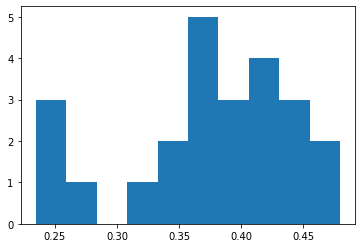

In [15]:
plt.hist(pd.DataFrame(minority_sim_dict)["mean_sim_score"])

In [ ]:
figure(figsize=(25, 10), dpi=1200)
sorted_index = np.argsort(minority_sim_dict["mean_sim_score"])

x_axis = np.arange(len(minority_sim_dict["word"]))
y_axis = [minority_sim_dict["mean_sim_score"][i] for i in sorted_index]
x_ticks = [minority_sim_dict["word"][i] for i in sorted_index]
plt.bar(x_axis, y_axis)
plt.xticks(x_axis, x_ticks, fontsize=40, rotation=90, fontweight='bold')
plt.ylabel("mean similarity score",fontsize=40, fontweight='bold')
plt.yticks(np.arange(0.1,1.1,0.1),fontsize=40, fontweight='bold')
plt.savefig(results_folder+"mean_similarity_score_of_minority_words_to_profane_words.pdf", bbox_inches='tight')

#### sim to profanet vector

In [ ]:
profane_vector = get_mean_vector(glove_wk_model, profane_words)
vec_minority_sim_dict = get_similarity_scores_between_avergare_target_vector_and_attribute_words(glove_wk_model, target_words, profane_vector)
pd.DataFrame(vec_minority_sim_dict).to_csv(results_folder+"minority_words_sim_to_profane_vector.csv")

In [ ]:
plt.hist(pd.DataFrame(vec_minority_sim_dict["sim_score"]))

In [ ]:
figure(figsize=(25, 10), dpi=1200)
sorted_index = np.argsort(vec_minority_sim_dict["sim_score"])

x_axis = np.arange(len(vec_minority_sim_dict["words"]))
y_axis = [vec_minority_sim_dict["sim_score"][i] for i in sorted_index]
x_ticks = [vec_minority_sim_dict["words"][i] for i in sorted_index]
plt.bar(x_axis, y_axis)
plt.xticks(x_axis, x_ticks, fontsize=40, rotation=90, fontweight='bold')
plt.ylabel("similarity score",fontsize=40, fontweight='bold')
plt.yticks(np.arange(0.1,1.1,0.1),fontsize=40, fontweight='bold')
plt.savefig(results_folder+"similarity_score_of_minority_words_to_profanity_vector.pdf", bbox_inches='tight')